# Experiment notes

What the method is not sensitive to:
- A small number of unique samples
- Repetitive samples
- A skewed distribution of samples

What the method is senstive to:
- The amount of training epochs and batch size, particularly with less data
- The number of inputs (more is worse)
- The number of hidden units (more is worse)

In [1]:
import torch
from torch import nn
import copy
import torchvision.datasets as datasets
import cv2

from env_helpers import *
from utils import *
from training import *

%matplotlib inline

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_data = mnist_trainset.data.reshape(-1, 28 * 28) / 255

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
cifar_data = cifar_trainset.data.reshape(-1, 3 * 32 * 32) / 255
cifar_data = torch.from_numpy(cifar_data).float()

C:\Users\ninja\.conda\envs\ml2\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Files already downloaded and verified


# Full MNIST Training

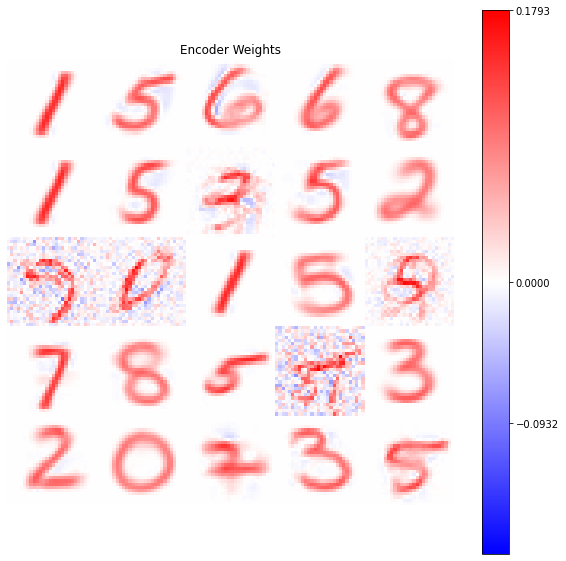

In [3]:
encoder = nn.Linear(28*28, 100)
encoder_weights = encoder.weight
initial_weights = copy.deepcopy(encoder_weights)
initial_weights.requires_grad = False
initial_weights = torch.normal(0, 1, (100, 784)).cuda()
new_weights = chu_train(mnist_data, initial_weights, 200, 3584)

draw_weights(new_weights, 5, 5, n_channels=1, sz=28, text='Encoder Weights');

# Reduced Training Data

In [3]:
def test_training(
        n_uniques, target_dataset_size, scale_size=-1, epochs=200,
        batch_size=2000, skewed=False, n_hidden_units=100, dataset_name='mnist',
        **kwargs):
    if dataset_name == 'mnist':
        data = mnist_data
        img_size = 28
        flat_dim = 28**2
    elif dataset_name == 'cifar':
        data = cifar_data
        img_size = 32
        flat_dim = 3 * 32**2

    mnist_samples = data[np.random.randint(0, len(data), size=n_uniques)]
    if scale_size > 0:
        mnist_samples = [cv2.resize(sample.reshape(28, 28), (scale_size, scale_size)) \
            for sample in mnist_samples.numpy()]
        mnist_samples = torch.FloatTensor(mnist_samples).view(-1, scale_size**2)
    img_dim = scale_size if scale_size > 0 else img_size

    # Make a skewed weighting of samples over training
    if skewed:
        sample_distr = np.random.normal(0, 1, n_uniques)
        sample_distr = np.exp(sample_distr)
        sample_distr = sample_distr / np.sum(sample_distr) * target_dataset_size
        sample_distr = np.round(sample_distr).astype(int)
        sample_distr = [max(1, x) for x in sample_distr]
        dataset_size = np.sum(sample_distr)
        skewed_dataset = np.zeros((dataset_size, flat_dim))
        dataset_idx = 0
        for sample, count in zip(mnist_samples, sample_distr):
            skewed_dataset[dataset_idx:dataset_idx+count] = sample
            dataset_idx += count
        print('Final dataset size:', dataset_size)
        dataset = torch.from_numpy(skewed_dataset).float().cuda()
    else:
        n_repeat = int(np.round(target_dataset_size / n_uniques))
        dataset = torch.repeat_interleave(mnist_samples, n_repeat, dim=0)
        dataset = dataset.cuda()

    # Shuffle the dataset
    dataset = dataset[torch.randperm(dataset.shape[0])]

    encoder = nn.Linear(flat_dim, n_hidden_units)
    encoder_weights = encoder.weight
    initial_weights = copy.deepcopy(encoder_weights)
    initial_weights.requires_grad = False
    initial_weights = torch.normal(0, 1, (n_hidden_units, flat_dim)).cuda()
    new_weights = chu_train(dataset, initial_weights, epochs, batch_size, **kwargs)

    if dataset_name == 'mnist':
        draw_weights(new_weights, 5, 5, n_channels=1, sz=img_dim, text='Encoder Weights');
    elif dataset_name == 'cifar':
        draw_colored_weights(new_weights, 5, 5, sz=(3, 32, 32), text='Encoder Weights');
        draw_weights(new_weights, 3, 3, n_channels=3, sz=img_dim, text='Encoder Weights');

    return new_weights

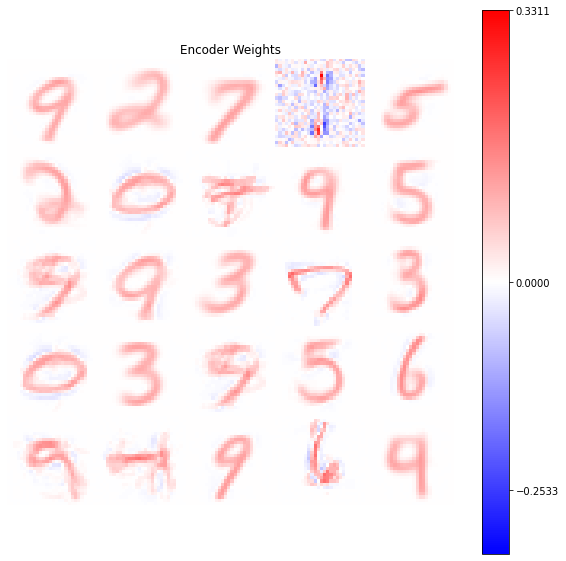

In [7]:
# Normal testing
test_training(
    n_uniques = len(mnist_trainset),
    target_dataset_size = len(mnist_trainset),
    skewed = False);

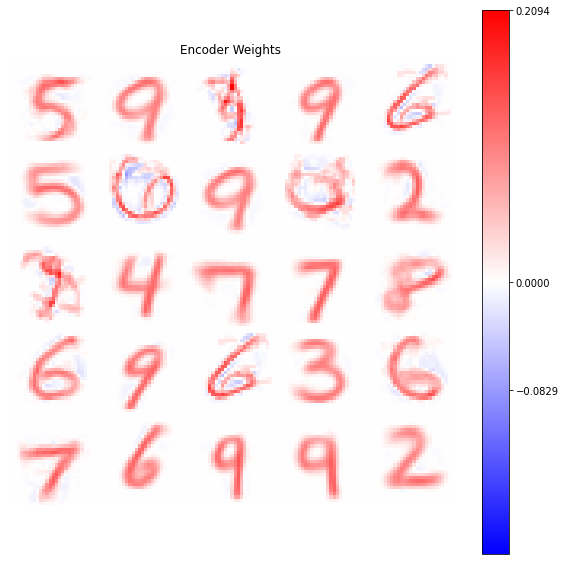

In [5]:
# Normal testing
test_training(
    n_uniques = len(mnist_trainset),
    target_dataset_size = len(mnist_trainset),
    skewed = False)

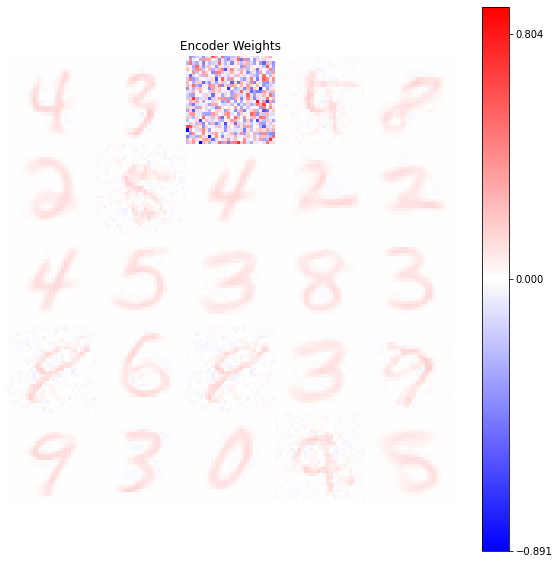

In [6]:
# 20K samples
test_training(
    n_uniques = 20000,
    target_dataset_size = 20000,
    skewed = False)

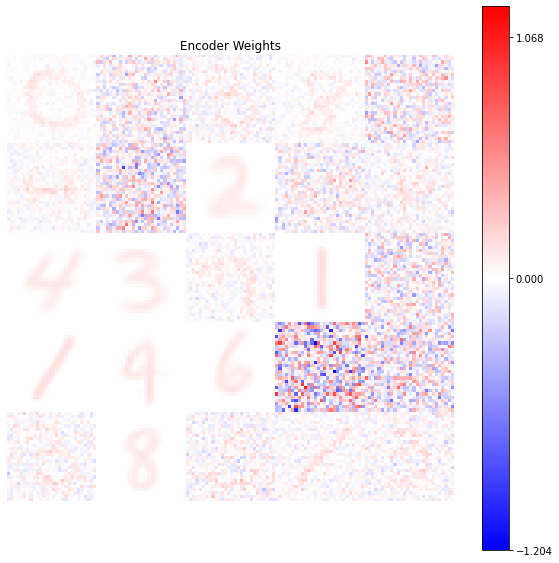

In [7]:
# 10K samples
test_training(
    n_uniques = 10000,
    target_dataset_size = 10000,
    skewed = False)

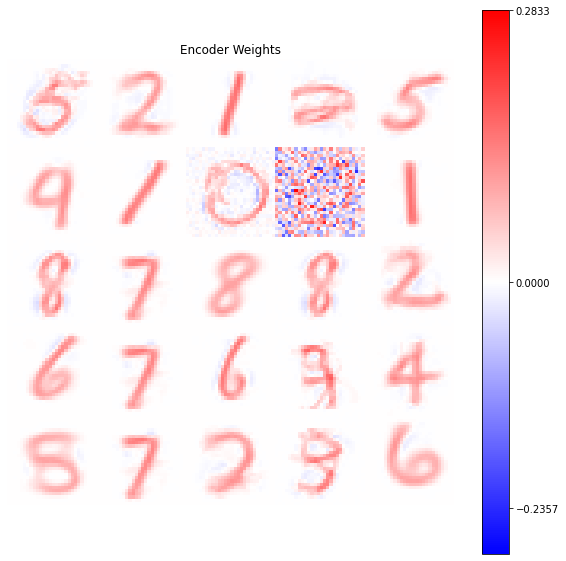

In [8]:
# 10K samples + double training
test_training(
    n_uniques = 10000,
    target_dataset_size = 10000,
    skewed = False,
    epochs = 400)

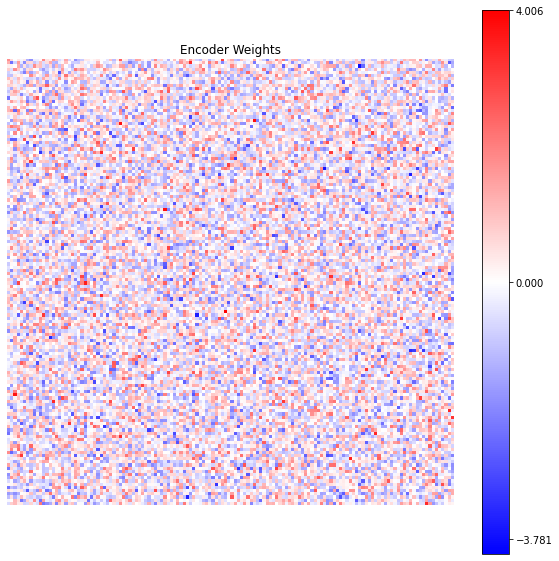

In [9]:
# 1K samples
test_training(
    n_uniques = 1000,
    target_dataset_size = 1000,
    skewed = False)

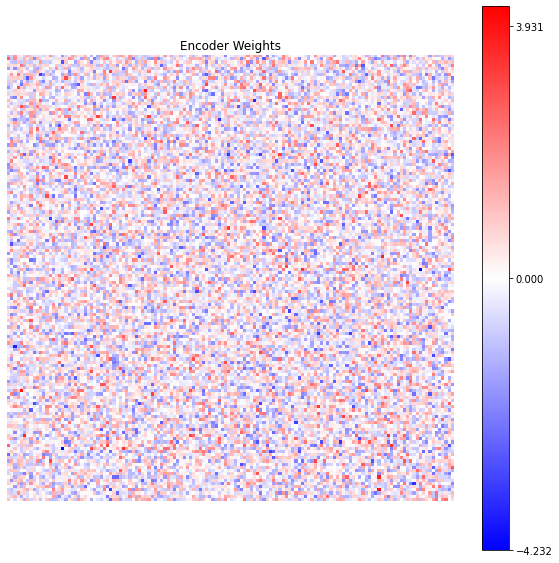

In [10]:
# 1K samples + 10x training
test_training(
    n_uniques = 1000,
    target_dataset_size = 1000,
    skewed = False,
    epochs = 2000)

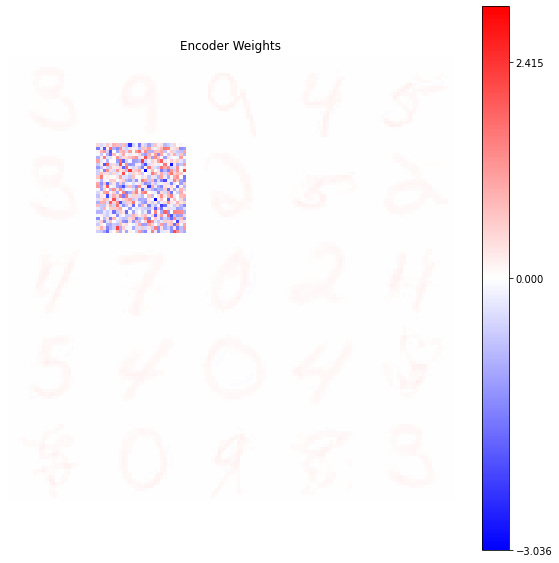

In [18]:
# 1K samples + batch size of 1
test_training(
    n_uniques = 1000,
    target_dataset_size = 1000,
    skewed = False,
    epochs = 200,
    batch_size = 1)

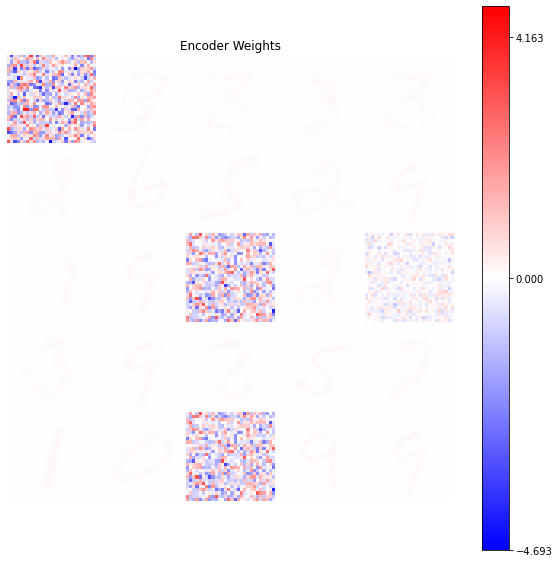

In [20]:
# 200 samples + batch size of 10
test_training(
    n_uniques = 200,
    target_dataset_size = 200,
    skewed = False,
    epochs = 2000,
    batch_size = 10)

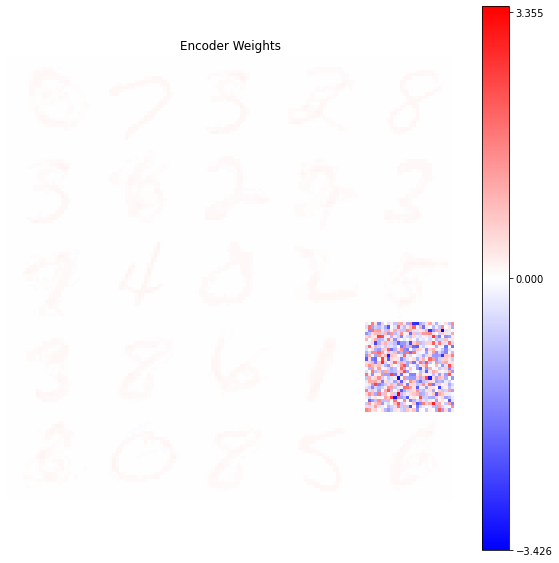

In [27]:
# 200 uniques, 60K samples
test_training(
    n_uniques = 200,
    target_dataset_size = 60000,
    skewed = False,
    epochs = 200)

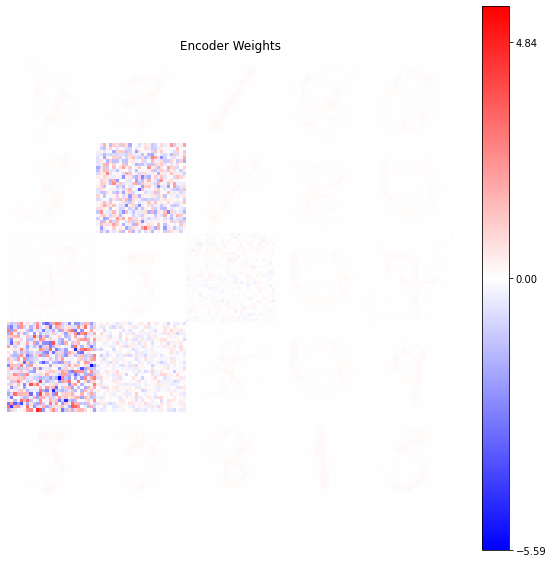

In [29]:
# 200 uniques, 10K samples, double training
test_training(
    n_uniques = 200,
    target_dataset_size = 10000,
    skewed = False,
    epochs = 400)

Final dataset size: 9997


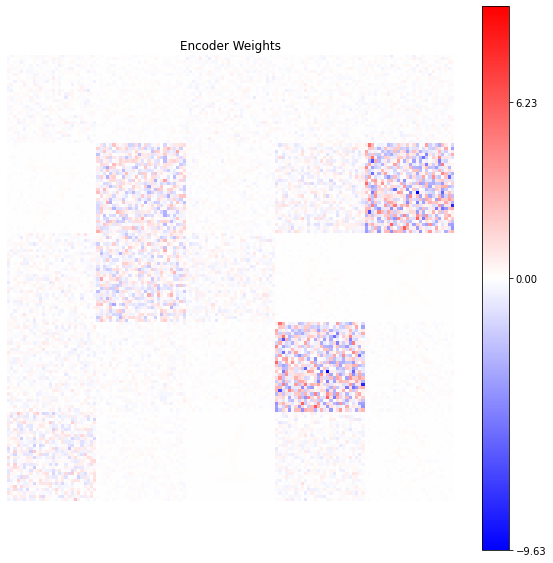

In [36]:
# 200 uniques, 10K samples, extra training, skewed
new_weights = test_training(
    n_uniques = 200,
    target_dataset_size = 10000,
    skewed = True,
    epochs = 500)

Final dataset size: 10004


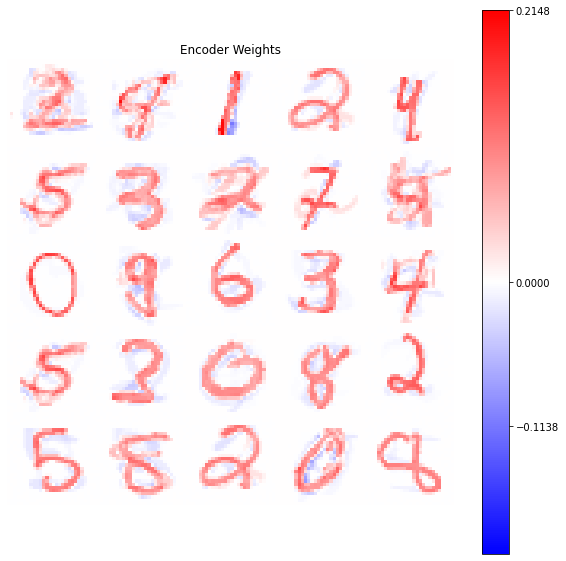

In [37]:
# 200 uniques, 10K samples, extra training, skewed
new_weights = test_training(
    n_uniques = 200,
    target_dataset_size = 10000,
    skewed = True,
    epochs = 1000)

Final dataset size: 10000


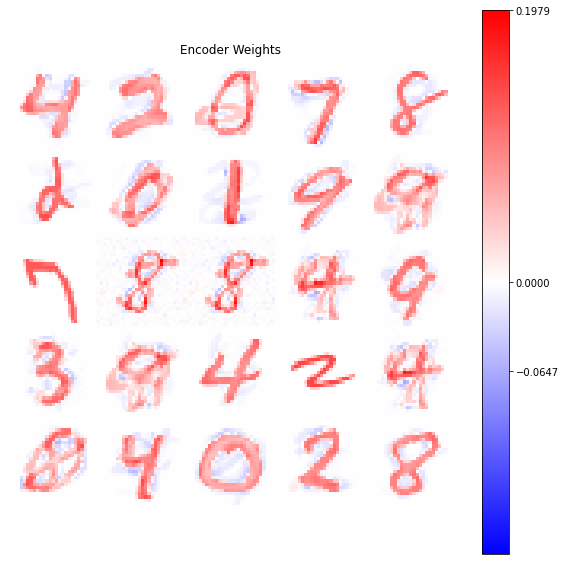

In [39]:
# 200 uniques, 10K samples, extra training, skewed
new_weights = test_training(
    n_uniques = 200,
    target_dataset_size = 10000,
    skewed = True,
    epochs = 500,
    batch_size = 1000)

Final dataset size: 10001


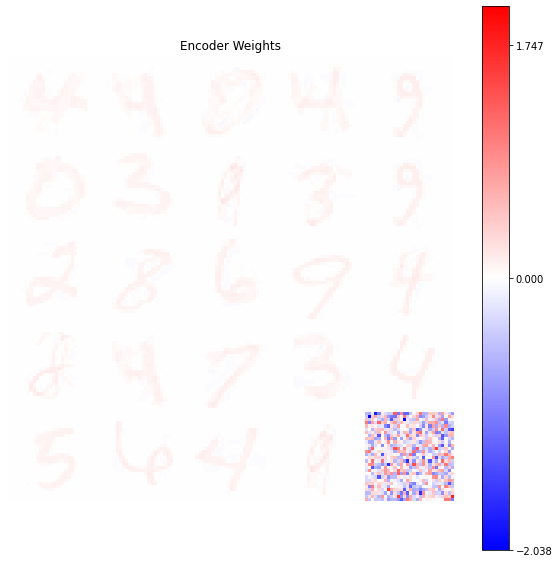

In [46]:
# 200 uniques, 10K samples, extra training, skewed
new_weights = test_training(
    n_uniques = 200,
    target_dataset_size = 10000,
    skewed = True,
    epochs = 500,
    batch_size = 1000)

Final dataset size: 10008


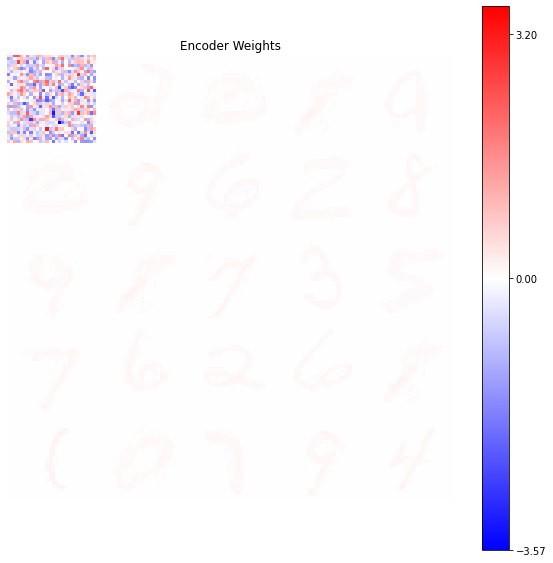

In [44]:
# 200 uniques, 10K samples, less training, skewed
new_weights = test_training(
    n_uniques = 200,
    target_dataset_size = 10000,
    skewed = True,
    epochs = 100,
    batch_size = 10)

# Scaled up image tests

torch.Size([60000, 784])
torch.Size([60000, 4761])


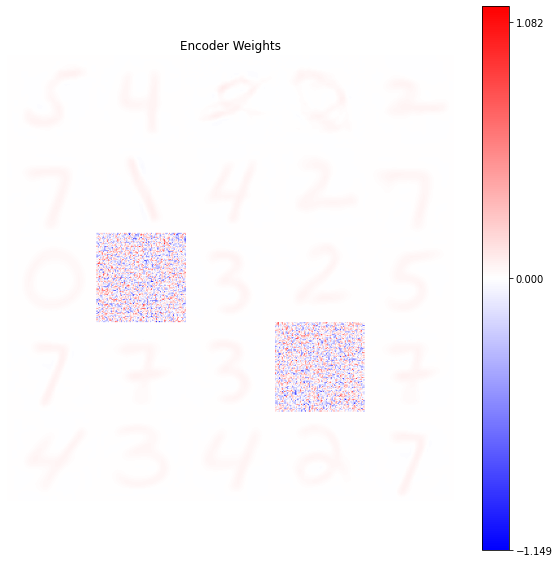

In [64]:
# Normal testing
test_training(
    n_uniques = len(mnist_trainset),
    target_dataset_size = len(mnist_trainset),
    skewed = False,
    scale_size = 70);

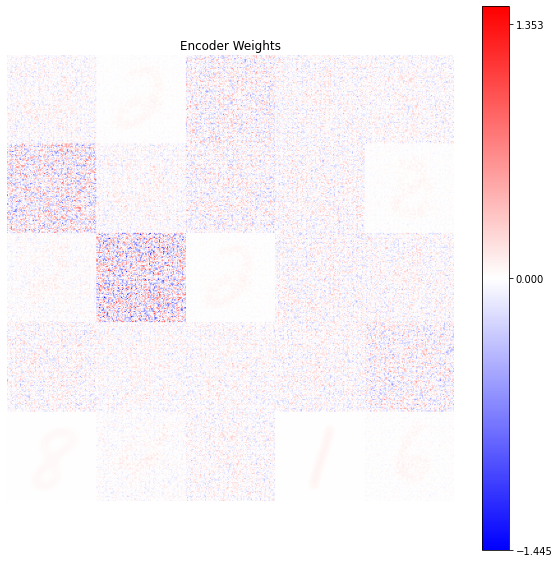

In [67]:
# 10K samples
test_training(
    n_uniques = 10000,
    target_dataset_size = 10000,
    skewed = False,
    scale_size = 70);

Final dataset size: 10002


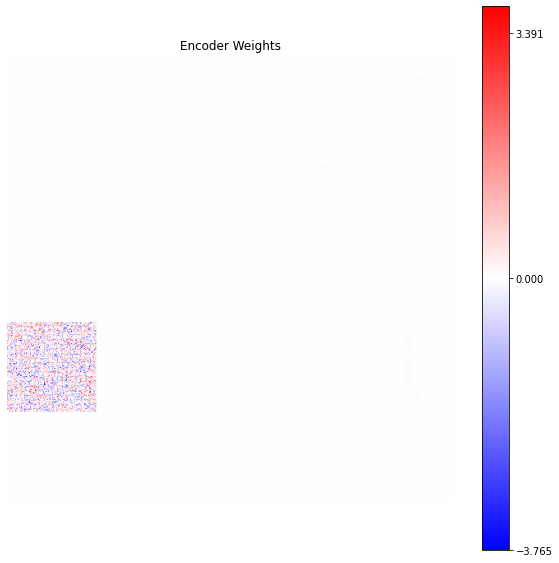

In [69]:
# 200 uniques, 10K samples, extra training, skewed
new_weights = test_training(
    n_uniques = 200,
    target_dataset_size = 10000,
    skewed = True,
    epochs = 500,
    batch_size = 1000,
    scale_size = 70);

Final dataset size: 10001


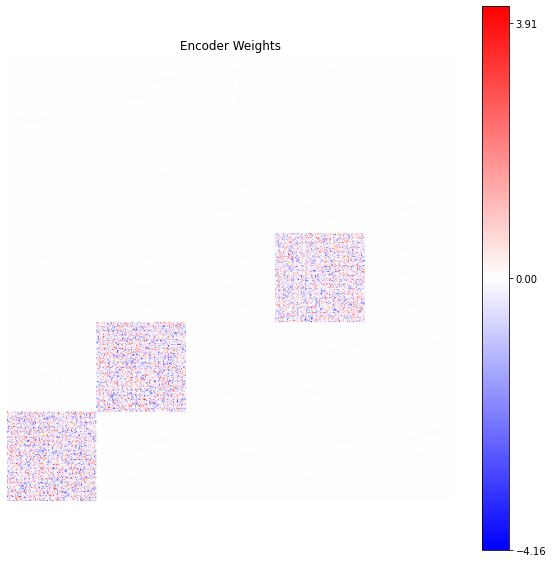

In [81]:
# 200 uniques, 10K samples, extra training, skewed
new_weights = test_training(
    n_uniques = 200,
    target_dataset_size = 10000,
    skewed = True,
    epochs = 2000,
    batch_size = 1000,
    scale_size = 70);

Final dataset size: 9997


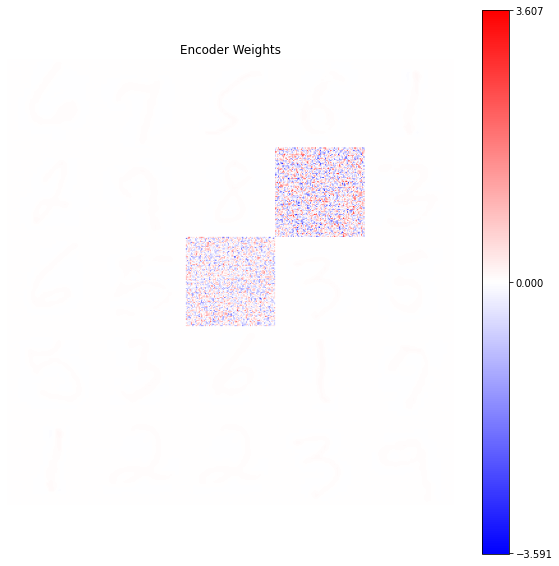

In [82]:
# 200 uniques, 10K samples, extra training, skewed
new_weights = test_training(
    n_uniques = 200,
    target_dataset_size = 10000,
    skewed = True,
    epochs = 2000,
    batch_size = 500,
    scale_size = 70);

Final dataset size: 10001


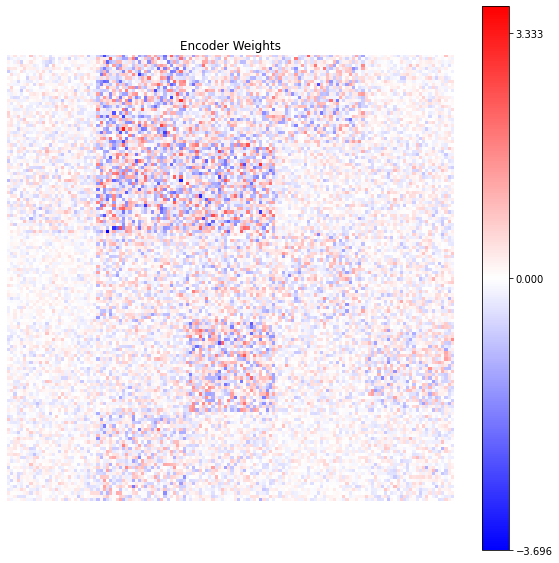

In [79]:
# 200 uniques, 10K samples, extra training, skewed
new_weights = test_training(
    n_uniques = 200,
    target_dataset_size = 10000,
    skewed = True,
    epochs = 500,
    batch_size = 1000,
    n_hidden_units = 625);

Final dataset size: 10006


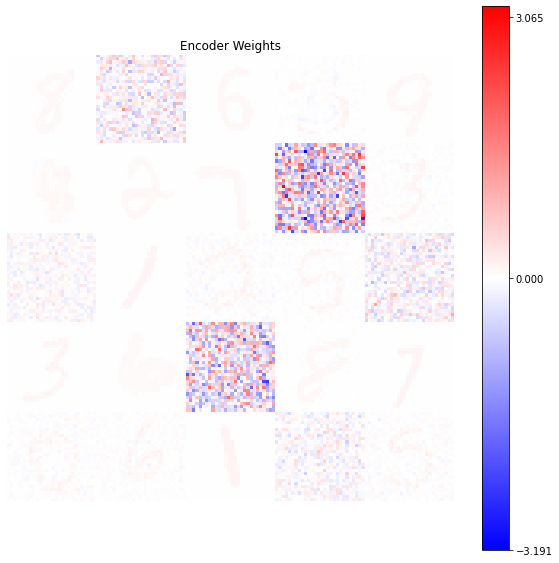

In [77]:
# 200 uniques, 10K samples, extra training, skewed
new_weights = test_training(
    n_uniques = 200,
    target_dataset_size = 10000,
    skewed = True,
    epochs = 2000,
    batch_size = 1000,
    n_hidden_units = 625);

# CIFAR-10 Testing

In [5]:
# Normal testing
all_weights = {}
for ahls in [0, 0.1, 0.2, 0.3]:
    for leb in [2, 3, 4, 5]:
        for rank in [2, 3]:
            print('ahls: {}\tleb: {}\trank: {}'.format(ahls, leb, rank))
            new_weights = test_training(
                n_uniques = len(cifar_trainset),
                target_dataset_size = len(cifar_trainset),
                skewed = False,
                epochs = 1000,
                dataset_name = 'cifar',
                n_hidden_units = 2000,
                anti_hebbian_learning_strength = ahls,
                lebesgue_norm = leb,
                rank = rank)
            all_weights[(ahls, leb, rank)] = new_weights

ahls: 0	leb: 2	rank: 2
ahls: 0	leb: 2	rank: 3
ahls: 0	leb: 3	rank: 2
ahls: 0	leb: 3	rank: 3
ahls: 0	leb: 4	rank: 2
ahls: 0	leb: 4	rank: 3
ahls: 0	leb: 5	rank: 2
ahls: 0	leb: 5	rank: 3
ahls: 0.1	leb: 2	rank: 2
ahls: 0.1	leb: 2	rank: 3
ahls: 0.1	leb: 3	rank: 2


e:\projects\continual_backprop\utils.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=size)


ahls: 0.1	leb: 3	rank: 3
ahls: 0.1	leb: 4	rank: 2
ahls: 0.1	leb: 4	rank: 3
ahls: 0.1	leb: 5	rank: 2
ahls: 0.1	leb: 5	rank: 3
ahls: 0.2	leb: 2	rank: 2
ahls: 0.2	leb: 2	rank: 3
ahls: 0.2	leb: 3	rank: 2
ahls: 0.2	leb: 3	rank: 3
ahls: 0.2	leb: 4	rank: 2
ahls: 0.2	leb: 4	rank: 3
ahls: 0.2	leb: 5	rank: 2
ahls: 0.2	leb: 5	rank: 3
